In [16]:
!pip install -q ultralytics seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.6 MB/s eta 0:00:00:00:0100:01


In [9]:
import os
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image

In [10]:
haar_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_cascade_path)


In [11]:
#FACE CROP FUNCTION USING OPENCV
def crop_face_from_image(path, output_size=224):
    img = cv2.imread(str(path))
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if len(faces) == 0:
        return None
    x, y, w, h = faces[0]
    # Optional: add padding
    pad = int(0.2 * w)
    x, y = max(0, x - pad), max(0, y - pad)
    w, h = w + 2 * pad, h + 2 * pad
    roi = img[y:y+h, x:x+w]
    if roi.shape[0] == 0 or roi.shape[1] == 0:
        return None
    resized = cv2.resize(roi, (output_size, output_size))
    return cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)



In [12]:
#CLASS LABEL GENERATOR
def get_class_label(group, subclass):
    if group == "incorrect_mask":
        return f"incorrect_{subclass}"
    elif group == "with_mask":
        return f"mask_{subclass}"
    elif group == "without_mask":
        return f"no_mask_{subclass}"
    return None


In [13]:
#DATA PROCESSING FUNCTION
def process_full_dataset(input_root, output_root, output_size=224):
    input_root = Path(input_root)
    output_root = Path(output_root)
    output_root.mkdir(parents=True, exist_ok=True)
    total = 0
    for group_dir in input_root.iterdir():
        if not group_dir.is_dir():
            continue
        group_name = group_dir.name
        for class_dir in group_dir.iterdir():
            if not class_dir.is_dir():
                continue
            subclass_name = class_dir.name
            label = get_class_label(group_name, subclass_name)
            if label is None:
                continue
            output_class = output_root / label
            output_class.mkdir(parents=True, exist_ok=True)
            for img_path in tqdm(class_dir.glob("*.jpg"), desc=f"{label}"):
                rgb = crop_face_from_image(img_path, output_size)
                if rgb is not None:
                    out_path = output_class / img_path.name
                    cv2.imwrite(str(out_path), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
                    total += 1
    print(f"\n✅ Processed {total} images")


In [14]:
#SPLIT FUNCTION
from sklearn.model_selection import train_test_split
def split_dataset(src_root, dst_root, val_ratio=0.2, test_ratio=0.1):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    for split in ['train', 'val', 'test']:
        for cls in os.listdir(src_root):
            os.makedirs(dst_root / split / cls, exist_ok=True)
    for cls in os.listdir(src_root):
        files = list((src_root / cls).glob("*.jpg")) + list((src_root / cls).glob("*.png"))
        if len(files) == 0:
            print(f"⚠️ Skipping class {cls} due to no images.")
            continue
        train_val, test = train_test_split(files, test_size=test_ratio, random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio/(1 - test_ratio), random_state=42)
        for f in train:
            shutil.copy(f, dst_root / 'train' / cls / f.name)
        for f in val:
            shutil.copy(f, dst_root / 'val' / cls / f.name)
        for f in test:
            shutil.copy(f, dst_root / 'test' / cls / f.name)

In [17]:
#TRAIN YOLOv8 CLASSIFIER
from ultralytics import YOLO
def train_model():
    model = YOLO("yolov8n-cls.pt")  # or yolov8s-cls.pt if RAM allows
    model.train(
        data="./dataset_split",
        epochs=30,
        imgsz=224,
        batch=32,
        patience=5,
        name="yolov8n-mask6class"
    )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [18]:
# Preprocess dataset
input_root = "/kaggle/input/face-mask-dataset/FMD_DATASET"
output_root = "/kaggle/working/processed_6class"
process_full_dataset(input_root, output_root)

no_mask_simple: 4000it [02:03, 32.30it/s]
no_mask_complex: 747it [01:11, 10.48it/s]
incorrect_mmc: 2500it [28:56,  1.44it/s]
incorrect_mc: 2500it [28:44,  1.45it/s]
mask_simple: 4000it [33:50,  1.97it/s]
mask_complex: 789it [02:06,  6.22it/s]


✅ Processed 10176 images


In [19]:
# 2. Split dataset
split_dataset(output_root, "/kaggle/working/dataset_split")

In [20]:
# 3. Train the YOLOv8 classifier
train_model()

100%|██████████| 5.31M/5.31M [00:00<00:00, 134MB/s]


Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./dataset_split, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n-mask6class, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrain

100%|██████████| 5.35M/5.35M [00:00<00:00, 116MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 799.6±252.9 MB/s, size: 24.1 KB)


train: Scanning /kaggle/working/dataset_split/train... 7119 images, 0 corrupt: 100%|██████████| 7119/7119 [00:02<00:00, 2973.28it/s]


train: New cache created: /kaggle/working/dataset_split/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 698.1±219.9 MB/s, size: 23.5 KB)


val: Scanning /kaggle/working/dataset_split/val... 2037 images, 0 corrupt: 100%|██████████| 2037/2037 [00:00<00:00, 3031.38it/s]

val: New cache created: /kaggle/working/dataset_split/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolov8n-mask6class
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30     0.426G      1.877         32        224:   3%|▎         | 7/223 [00:01<00:24,  8.98it/s]

       1/30     0.426G      1.859         32        224:   5%|▍         | 11/223 [00:01<00:25,  8.35it/s]
100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 14.13it/s]

                   all      0.873      0.995



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.86it/s]

                   all      0.893      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 14.31it/s]

                   all      0.888      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.84it/s]


                   all      0.891      0.996

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.97it/s]

                   all        0.9      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 12.36it/s]

                   all      0.897      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.58it/s]

                   all      0.898      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.91it/s]

                   all      0.903      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.85it/s]

                   all      0.906      0.998



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.604G     0.2266         15        224: 100%|██████████| 223/223 [00:22<00:00, 10.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.49it/s]

                   all      0.903      0.998



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.615G     0.2237         15        224: 100%|██████████| 223/223 [00:21<00:00, 10.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 14.05it/s]

                   all        0.9      0.998



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.619G     0.2222         15        224: 100%|██████████| 223/223 [00:22<00:00,  9.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.74it/s]

                   all      0.901      0.997



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.631G     0.2159         15        224: 100%|██████████| 223/223 [00:21<00:00, 10.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.91it/s]

                   all      0.904          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.635G     0.1963         15        224: 100%|██████████| 223/223 [00:22<00:00, 10.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.77it/s]

                   all      0.899      0.999
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 9, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



14 epochs completed in 0.096 hours.
Optimizer stripped from runs/classify/yolov8n-mask6class/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/yolov8n-mask6class/weights/best.pt, 3.0MB

Validating runs/classify/yolov8n-mask6class/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,442,566 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/dataset_split/train... found 7119 images in 6 classes ✅ 
val: /kaggle/working/dataset_split/val... found 2037 images in 6 classes ✅ 
test: /kaggle/working/dataset_split/test... found 1020 images in 6 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:02<00:00, 13.31it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.904          1
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolov8n-mask6class


In [22]:
#  4. OPTIONAL: Evaluate model on test set (Simple Accuracy Calc)
def evaluate_model_on_test_set(model_path, test_dir, img_size=224):
    model = YOLO(model_path)
    class_names = sorted(os.listdir(test_dir))
    correct = 0
    total = 0
    for cls in class_names:
        cls_path = os.path.join(test_dir, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                results = model(img_path, imgsz=img_size, verbose=False)[0]
                pred_idx = int(results.probs.top1)
                pred_label = results.names[pred_idx]
                if pred_label == cls:
                    correct += 1
                total += 1
            except:
                continue
    acc = correct / total if total > 0 else 0
    print(f"✅ Test Accuracy: {acc:.2%} on {total} images")

# Evaluate the model (optional but recommended)
model_path = "/kaggle/working/runs/classify/yolov8n-mask6class/weights/best.pt"
test_dir = "/kaggle/working/dataset_split/test"
evaluate_model_on_test_set(model_path, test_dir)

✅ Test Accuracy: 89.61% on 1020 images


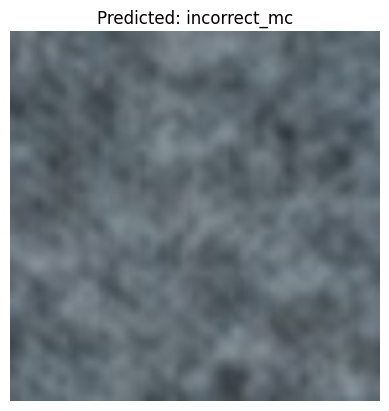

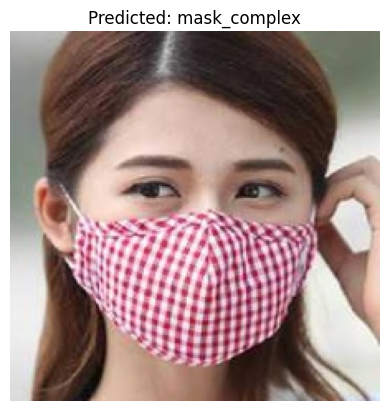

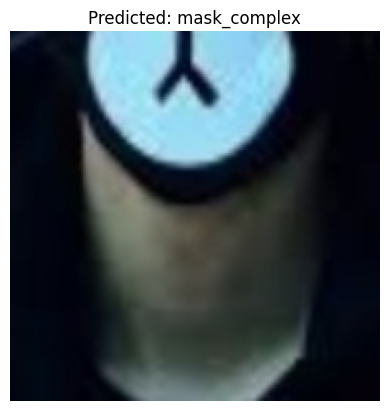

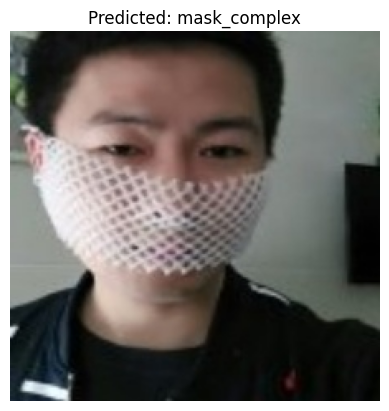

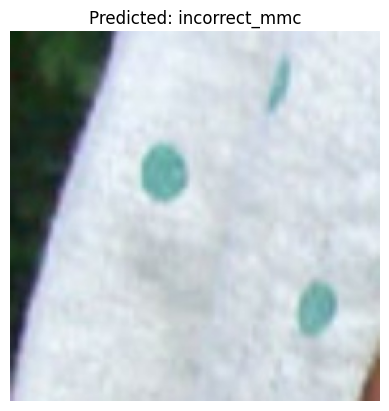

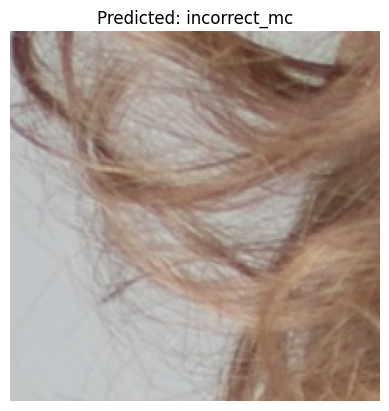

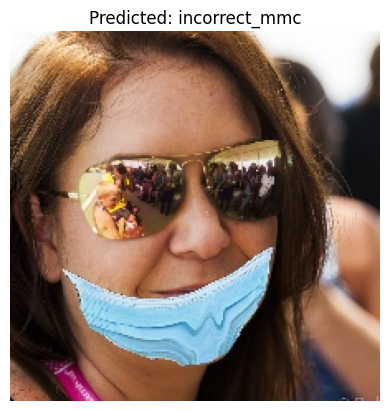

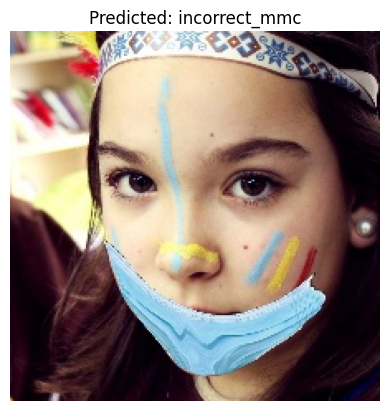

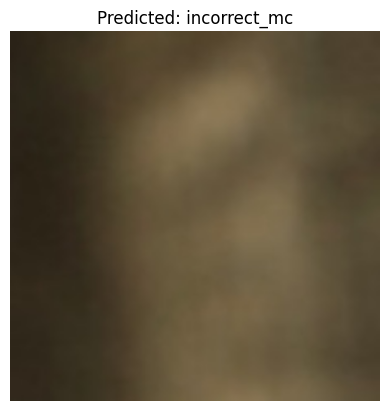

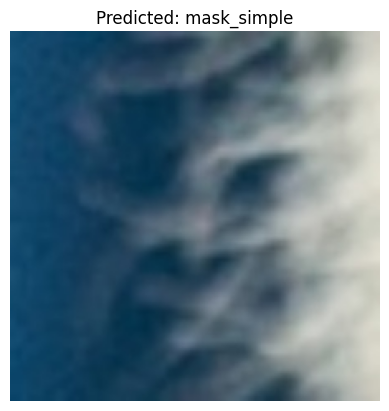

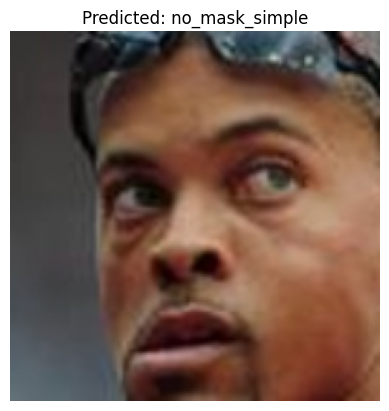

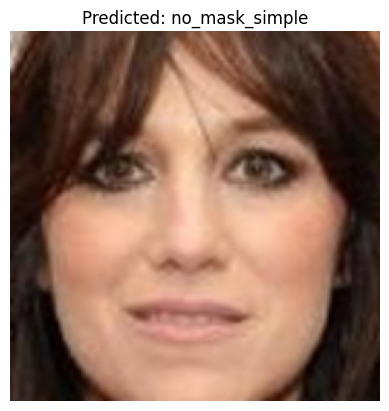

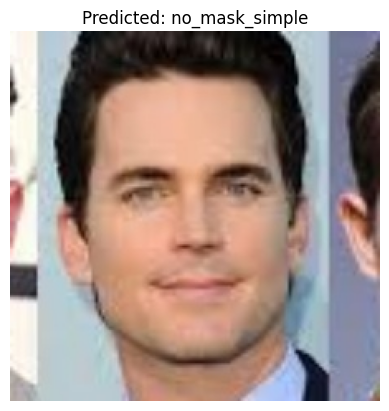

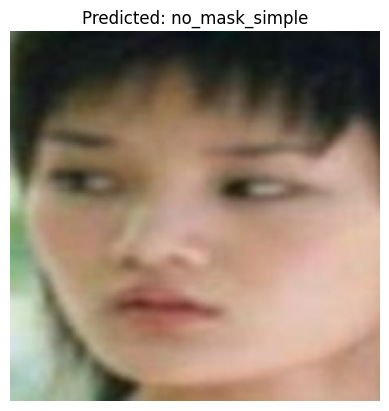

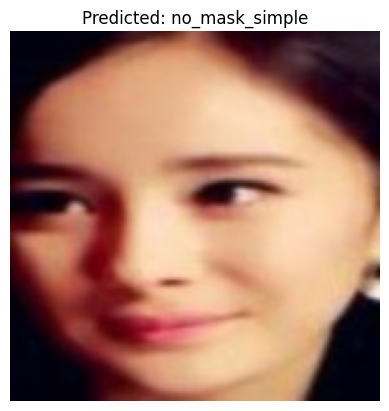

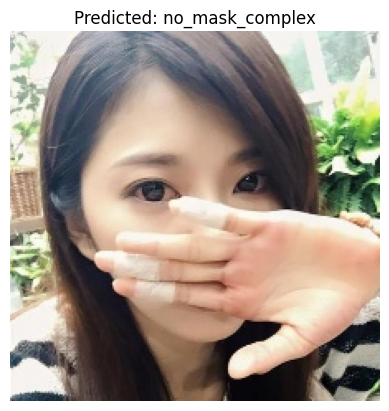

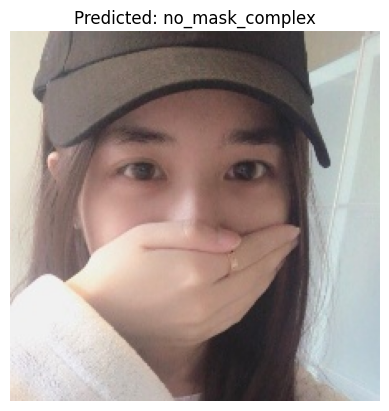

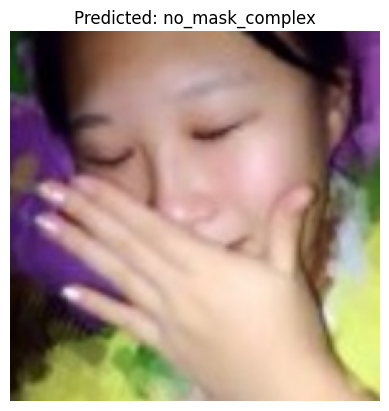

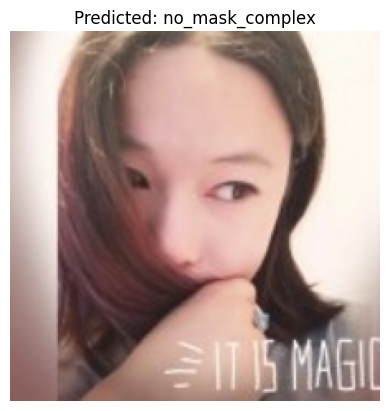

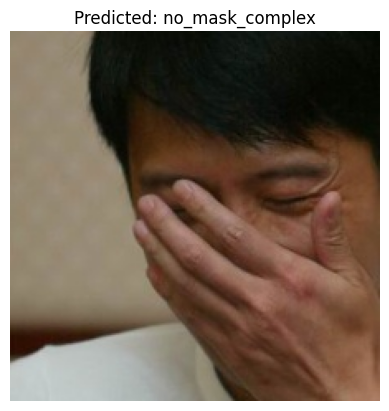

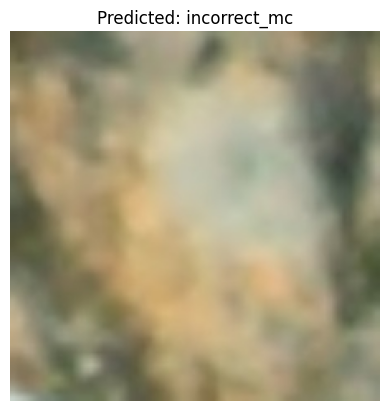

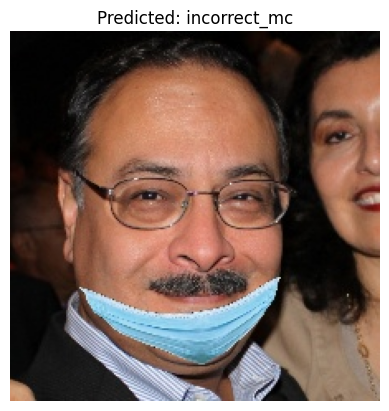

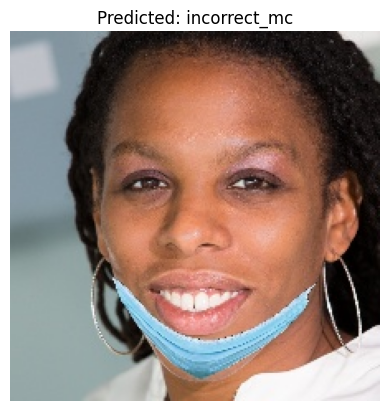

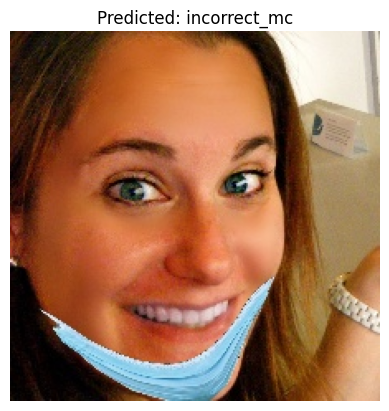

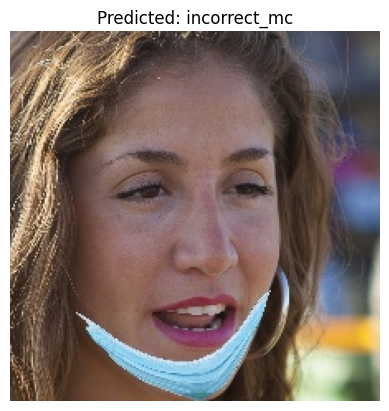

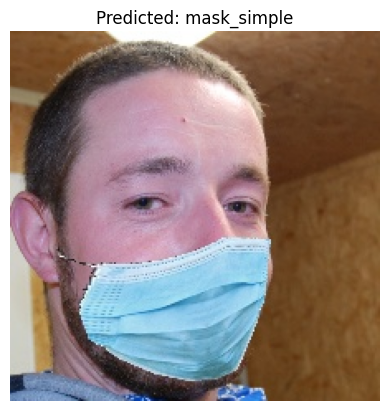

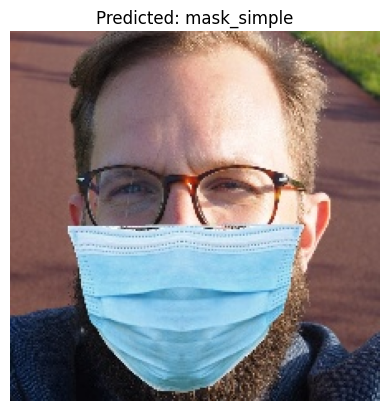

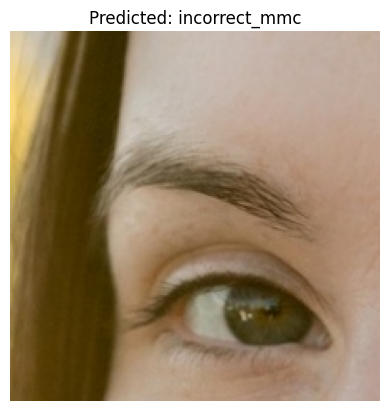

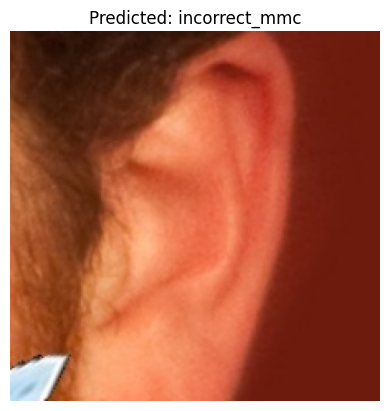

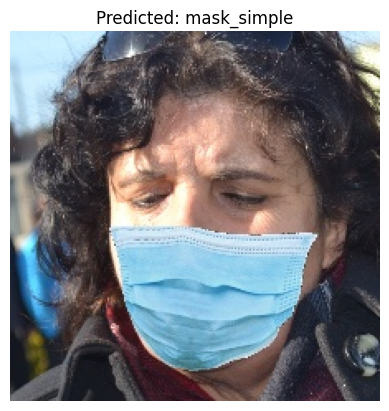

In [23]:
def show_predictions(model_path, test_dir, num_samples=5):
    model = YOLO(model_path)
    class_dirs = list(Path(test_dir).glob("*"))
    samples = []
    for cls in class_dirs:
        samples += random.sample(list(cls.glob("*.jpg")), min(len(list(cls.glob("*.jpg"))), num_samples))
    for img_path in samples:
        img = Image.open(img_path)
        results = model(str(img_path), imgsz=224, verbose=False)[0]
        pred_label = results.names[int(results.probs.top1)]
        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}")
        plt.axis('off')
        plt.show()

# Call the function
show_predictions(model_path, test_dir)
